In [49]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time
import json
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

import cv2
import itertools
import random
from collections import Counter
from glob import iglob

In [50]:
#waktu awal proses eksekusi
start = time.time()

In [51]:
zip_file='Plant_leaf_diseases_dataset_without_augmentation.zip'

#definisikan file latih dan validasi
data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [52]:
#label mapping kelas yang ada
with open('PlantVillage/categories.json', 'r') as f:
    category_to_name = json.load(f)
    classes = list(category_to_name.values())
    
print (classes)

['Background_without_leaves', 'Corn____Cercospora_leaf_spot Gray_leaf_spot', 'Corn____Common_rust_', 'Corn____Northern_Leaf_Blight', 'Corn____healthy']


In [53]:
#rescale pixel, batch size
pixels = 72
image_size = (pixels, pixels)
batch_size = 128

In [54]:
#preprocessing data
#normalisasi dari `[0, 255]` range ke `[0, 1]` range
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=None, 
    color_mode="rgb", 
    class_mode="categorical", 
    target_size=image_size, 
    batch_size=batch_size)

do_data_augmentation = True

#normalisasi dan augmentasi data
if do_data_augmentation:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale = 1./255, 
        rotation_range=40, 
        horizontal_flip=True, 
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        shear_range=0.2, 
        zoom_range=0.2, 
        fill_mode='nearest' )
else:
    train_datagen = validation_datagen

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=None,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=image_size,
    batch_size=batch_size)

Found 998 images belonging to 5 classes.
Found 3997 images belonging to 5 classes.


In [55]:
#bangun model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(72, (3, 3), activation='relu', input_shape=(72, 72, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(input_shape=image_size+(3,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 70, 70, 72)        2016      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 72)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 33, 33, 32)        20768     
_________________________________________________________________
flatten_3 (Flatten)          (None, 34848)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               4460672   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
__________

In [57]:
#adam optimizer
learning_rate = 0.001
model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=learning_rate), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [58]:
#latih model dengan 40 epochs
epochs = 10
epochs_steps = train_generator.samples//train_generator.batch_size
validation_steps = validation_generator.samples//validation_generator.batch_size

with tf.device('/device:GPU:0'):
    history = model.fit(
        train_generator, 
        steps_per_epoch=epochs_steps, 
        epochs=epochs, 
        validation_data=validation_generator, 
        validation_steps=validation_steps)

Epoch 1/10
31/31 [==============================] - 31s 1s/step - loss: 1.0592 - acc: 0.5849 - val_loss: 0.7231 - val_acc: 0.7087
Epoch 2/10
31/31 [==============================] - 31s 986ms/step - loss: 0.4302 - acc: 0.8239 - val_loss: 0.3683 - val_acc: 0.8415
Epoch 3/10
31/31 [==============================] - 31s 988ms/step - loss: 0.3348 - acc: 0.8542 - val_loss: 0.2899 - val_acc: 0.8739
Epoch 4/10
31/31 [==============================] - 31s 986ms/step - loss: 0.3441 - acc: 0.8564 - val_loss: 0.3016 - val_acc: 0.8683
Epoch 5/10
31/31 [==============================] - 31s 993ms/step - loss: 0.2851 - acc: 0.8741 - val_loss: 0.2645 - val_acc: 0.8940
Epoch 6/10
31/31 [==============================] - 30s 977ms/step - loss: 0.2911 - acc: 0.8853 - val_loss: 0.3342 - val_acc: 0.8627
Epoch 7/10
31/31 [==============================] - 31s 992ms/step - loss: 0.2696 - acc: 0.8910 - val_loss: 0.2457 - val_acc: 0.8973
Epoch 8/10
31/31 [==============================] - 31s 991ms/step - los

In [59]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


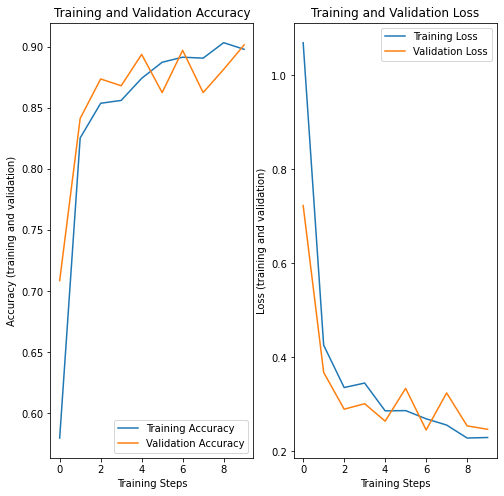

In [60]:
#plot accuracy dan loss pada data latih dan data validasi
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")

plt.show()

In [61]:
#fungsi load image
def load_image(filename):
    img = cv2.imread(os.path.join(validation_dir, filename))
    img = cv2.resize(img, (image_size[0], image_size[1]) )
    img = img /255
    
    return img

#fungsi predict image dari model yang dibangun
def predict_image(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Corn___healthy, file: Corn___healthy/image (1070).jpg
PREDICTED: class: Corn____healthy, confidence: 0.998986


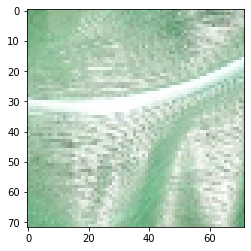

<Figure size 432x288 with 0 Axes>

SOURCE: class: Corn___healthy, file: Corn___healthy/image (1130).jpg
PREDICTED: class: Corn____healthy, confidence: 0.998417


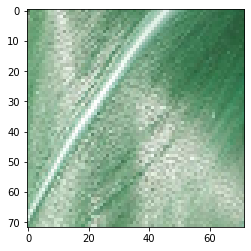

SOURCE: class: Corn___Common_rust, file: Corn___Common_rust/image (1087).JPG
PREDICTED: class: Corn____Common_rust_, confidence: 1.000000


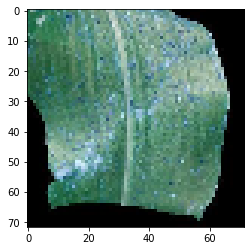

<Figure size 432x288 with 0 Axes>

SOURCE: class: Corn___healthy, file: Corn___healthy/image (1061).jpg
PREDICTED: class: Corn____healthy, confidence: 0.999603


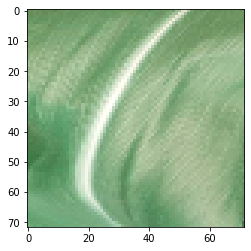

<Figure size 432x288 with 0 Axes>

SOURCE: class: Corn___Northern_Leaf_Blight, file: Corn___Northern_Leaf_Blight/image (808).JPG
PREDICTED: class: Background_without_leaves, confidence: 0.730942


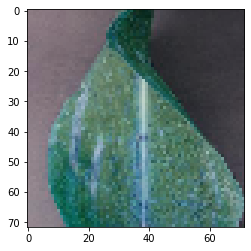

<Figure size 432x288 with 0 Axes>

In [62]:
#prediksi n-gambar secara random
n = 5
for idx, filename in enumerate(random.sample(validation_generator.filenames, n)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict_image(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
# waktu akhir proses eksekusi
end = time.time()

In [64]:
#lama proses eksekusi
print("Lama eksekusi: ", end-start, "s")

Lama eksekusi:  313.0597450733185 s
